# Analysis of Financial Time Series with Persistent Homology

<hr>
<hr>

## a. Description

This project's goal is to analyze the evolution of daily returns of four key US stock markets indices (i.e. DowJones, Nasdaq, Russell2000, SP500) over the period 1989 – 2016 using persistent homology, following the approach proposed in "[Topological Data Analysis of Financial Time Series: Landscapes of Crashes](https://arxiv.org/pdf/1703.04385.pdf)" by Marian Gidea and Yuri Katz.

A classical approach in Topological Data Analysis (TDA) to extract topological features from multivariate time-series with values in $R^d$ ($d = 4$ here, since we are considering the evolution of four indices) consists in using a sliding window of fixed length $w$ to generate a sequence of $w$ points in $R^d$.

Using the Vietoris-Rips filtration, the persistence diagram of each of these point clouds is then computed and used as a topological feature for further analysis or processing of the initial data. This project aims at reproducing the experiments in the paper cited above and explore and discuss a few variants.


## b. Notebook Steps

<u>**Step 1**</u> -- Perform simple data exploration on the available dataset and note important/applicable points from the provided article (we will specifically pay attention to Sections 3.1 and 4).

<u>**Step 2**</u> -- Write a function to compute persistence landscapes *WITHOUT* using the GUDHI library. This function should take as input a persistence diagram $D$ (in the GUDHI format), a dimension $k$, the endpoints
$x_{min}$, $x_{max}$ of an interval, the number $n$ of nodes of a regular grid on the interval $[x_{min}, x_{max}]$ and a number of landscapes $m$, and should output an $m \times n$ array storing the values of the first $m$ landscapes of the persistence diagram $D$ on the nodes of the grid. Check on some simple examples that your code
is correct.

<u>**Step 3**</u> -- Use the landscape function to run the experiments done in Section 4 of the paper, using windows of length $w = 40$ and $w = 80$ and $w = 120$. Compare your results to the ones provided in the article: are they similar or not?

<u>**Step 4**</u> -- Propose and experiment other methods, than just computing the norm of landscapes and briefly discuss and compare your results to the ones in Section 4 of the paper.

## c. Library Imports

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## d. Function Declarations

In [2]:
def compute_log_returns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given an input standardized stock price dataframe, transforms
    the dataframe in its relative-valued counterpart:
    - prices are transformed into their log-return
    - volume is transformed into a percent change
    """
    # Copies the input dataframe and updates the column names
    new_df = df.copy()
    # Computes the log-returns for each price column
    price_columns = ["open", "high", "low", "close", "adj_close"]
    for column in price_columns:
        log_price            = np.log(new_df[column])
        log_price_shifted    = np.log(new_df[column].shift(1))
        new_df[column+"_lr"] = log_price - log_price_shifted
    # Computes the volume percent change
    new_df["volume_pct_change"]=new_df["volume"].pct_change()
    return new_df

def format_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Formats the column names of the dataframe:
    - lower casing
    - space swapped for underscore
    """
    # Declares useful anonymous function
    format_column_name = lambda x: x.lower().replace(" ", "_")
    # Copies the input dataframe and updates the column names
    new_df = df.copy()
    new_df.columns = list(map(format_column_name, new_df.columns))
    return new_df

def plot_price_data(
    df_list: list,  legend: list, 
    target_column: str, title: str
) -> None:
    """
    Given a list of standardized stock price data, plots the
    Adjusted Close value across the whole available timeline.
    """
    plt.figure()
    # Fixes x-ticks interval to c. a year
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=365))
    for df in df_list:
        plt.plot(df["date"].tolist(), 
                 df[[target_column]],
                 linewidth=.5)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.legend(legend)
    plt.show()
    
def reverse_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Revert the order of a dataframe.
    """
    # Copies the input dataframe and updates the column names
    new_df = df.copy()[::-1]
    new_df.index = range(0, len(df))
    return new_df

<hr>
<hr>

# 1. Step 1 - Paper Summary and Data Pre-processing/Exploration

### 1.1 Notes on the paper

<u>The paper's motivation(s):</u>

Sharp changes in the behavior of financial markets produce deep social, political and economic impacts, destabilizing economies, nations and people's lives at a systemic level (e.g. 2000-2001 Dotcom Bubble, 2008 Financial Crisis, 2012 Euro Debt Crisis, etc.). Predicting such changes corresponds to a large area of research in the field of econometrics (e.g. the development of the co-value-at-risk, or CoVaR, by Tobias Adrian and Markus Brunnermeier in the [paper of the same name](https://www.aeaweb.org/articles?id=10.1257/aer.20120555), American Economic Review, Vol.106, No.7, July 2016) which has a strong influence on policymaking worldwide.

The paper at hand, "[Topological Data Analysis of Financial Time Series: Landscapes of Crashes](https://arxiv.org/pdf/1703.04385.pdf)" by Marian Gidea and Yuri Katz, proposes the use of persistence homology to highlight such sharp changes in financial markets -- with predictive capacity. Furthermore, since financial markets are complex systems that are hard to model, topological data analysis can help analyze the data as it does not require any information about the underlying stochastic process.


<u>The paper's data:</u>

The paper analyses the 4-dimensional time series of daily log-returns of 4 key stock market indexes (S&P500, Dow Jones, NASDAQ, Russel 2000).

<u>The paper's proposed workflow:</u>

The paper proposes a topological analytic framework to study financial market behaviors which relies on the following workflow:

1. Choice of preliminary TDA parameters (sliding/scaling window $w$, parameter $p$ of end $L^p$ norms)
2. Extraction of time-dependent point clouds from the underlying dataset
3. Measuring topological persistence (i.e. persistent homology)
    - From each point cloud dataset, construction of simplicial complex filtration
    - Construction of persistence diagrams (diagram point coordinates)
4. Encoding in a persistence landscape
5. Computing of $L^p$ norm times series
6. Visualization of highlighted trends

Given a sliding window of size $w$ (with a shift step of 1 day), the paper computes for each 4-dimensional point cloudes two $L^p$ norm time series (with $p\in\{1, 2\}$). 


### 1.2 Data exploration

<u>Importing the four stock index .csv files:</u>

In [3]:
# Sets path and file names
dpath = "data/"
files = ["dowjones.csv", "nasdaq.csv", "russel2000.csv", "sp500.csv"]

# Imports
dowjones   = format_dataframe(pd.read_csv(dpath+files[0]))
nasdaq     = format_dataframe(pd.read_csv(dpath+files[1]))
russel2000 = format_dataframe(pd.read_csv(dpath+files[2]))
sp500      = format_dataframe(pd.read_csv(dpath+files[3]))

<u>Reversing the datasets:</u>

We remark that the four datasets are sorted from the most recent to the oldest entry. We invert this order.

In [4]:
dowjones   = reverse_dataframe(dowjones)
nasdaq     = reverse_dataframe(nasdaq)
russel2000 = reverse_dataframe(russel2000)
sp500      = reverse_dataframe(sp500)

<u>Describing the four stock index datasets:</u>

In [5]:
dowjones.describe()

,open,high,low,close,volume,adj_close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,9105.862283,9164.009674,9046.451886,9108.768028,1.327529e+08,9108.768028
std,4591.493765,4612.191784,4569.933694,4592.338602,1.080034e+08,4592.338602
min,1892.410034,1903.349976,1845.989990,1879.140015,5.170000e+06,1879.140015
25%,4035.600098,4054.629883,4025.580078,4038.370117,3.070000e+07,4038.370117
50%,9961.139648,10036.940430,9875.129883,9961.919922,1.048900e+08,9961.919922
75%,11872.070312,11968.179688,11803.040039,11871.839844,2.139300e+08,11871.839844
max,19559.939453,19664.970703,19527.830078,19614.810547,7.384400e+08,19614.810547


In [6]:
nasdaq.describe()

,open,high,low,close,volume,adj_close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,2046.851121,2061.155424,2030.069391,2046.431813,1.272756e+09,2046.431813
std,1308.226234,1316.374729,1298.087048,1307.761834,8.269404e+08,1307.761834
min,325.100006,325.700012,323.000000,325.399994,4.421000e+07,325.399994
25%,804.460022,808.690002,804.460022,807.380005,3.488100e+08,807.380005
50%,1957.260010,1972.310059,1939.560059,1959.239990,1.545720e+09,1959.239990
75%,2658.530029,2675.209961,2637.659912,2657.219971,1.922070e+09,2657.219971
max,5394.149902,5425.520020,5389.100098,5417.359863,4.553600e+09,5417.359863


In [7]:
russel2000.describe()

,open,high,low,close,volume,adj_close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,541.634331,545.258122,537.669418,541.784923,1.903291e+07,541.784923
std,310.343577,312.363606,308.122820,310.423800,1.785974e+07,310.423800
min,118.309998,118.959999,118.019997,118.300003,5.720000e+05,118.300003
25%,264.049988,265.029999,263.179993,264.140015,3.225700e+06,264.140015
50%,480.959991,484.850006,475.980011,481.130005,1.283300e+07,481.130005
75%,736.500000,742.190002,729.750000,736.590027,3.336120e+07,736.590027
max,1364.430054,1386.449951,1363.699951,1386.369995,1.145623e+08,1386.369995


In [8]:
sp500.describe()

,open,high,low,close,volume,adj_close
count,7301.000000,7301.000000,7301.000000,7301.000000,7.301000e+03,7301.000000
mean,1048.014023,1054.464612,1041.154037,1048.282910,1.904413e+09,1048.282910
std,515.875484,518.431655,513.113535,515.946592,1.784001e+09,515.946592
min,242.649994,244.250000,240.169998,242.630005,1.499000e+07,242.630005
25%,490.049988,492.890015,490.049988,491.880005,3.247100e+08,491.880005
50%,1111.469971,1118.739990,1105.270020,1111.089966,1.286300e+09,1111.089966
75%,1358.849976,1367.410034,1348.030029,1359.880005,3.335710e+09,1359.880005
max,2241.129883,2251.689941,2237.570068,2246.189941,1.145623e+10,2246.189941


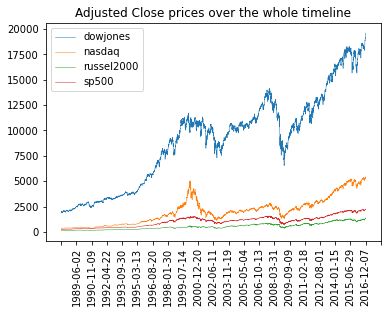

In [9]:
legend = ["dowjones", "nasdaq", "russel2000", "sp500"]

plot_price_data([dowjones, nasdaq, russel2000, sp500], legend, "adj_close",
                "Adjusted Close prices over the whole timeline")

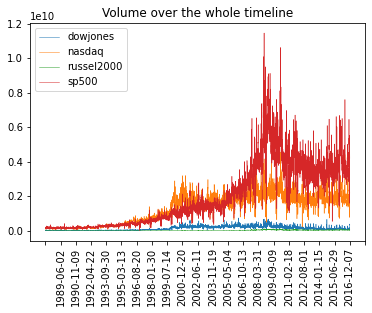

In [10]:
plot_price_data([dowjones, nasdaq, russel2000, sp500], legend, "volume",
                "Volume over the whole timeline")

### 1.3 Computing log-returns and volume percent changes

The logarithm of returns is an ubiquitous quantitative finance transformation of time series (and especially price) data. 

> Given a price time series $P$ of length $n\in\mathbb{N}_+$ with components $p_i\,\,\forall i\in\{0,\ldots,n\}$.
>
> $P$ can be transformed into a times series $R$ of returns $r_i\,\,\forall i\in\{1,\ldots,n\}$ such that:

\begin{align}
\forall i\in\{1,\ldots,n\},\,r_i &= \frac{p_i-p_{i-1}}{p_{i-1}}
\end{align}

The main benefit of using relative metrics like returns compared to absolute metrics like prices is normalization, a requirement for many multidimensional statistical analysis setups. However, it is more common to encounter logarithmic returns due to several valuable properties.

\begin{align}
\forall i\in\{1,\ldots,n\},\,r_i &= log(p_i)-log(p_{i-1})
\end{align}

<u>Properties of log-returns:</u>

1. **Log-normality**: Prices are usually assumed to be log-normally distributed in finance.

2. **Approximate raw-log equality**: Given $r^{\text{absolute}}_i$ the return at timestep $i$ of a price time series $P$, and $r_i^{\text{log}}$ the corresponding log-return, we find the following approximation when $r^{\text{absolute}}_i<<1$:

$$\forall i\in\{1,\ldots,n\},\,r^{\text{absolute}}_i\approx log(1+r^{\text{absolute}}_i) = r_i^{\text{log}}$$

3. **Time additivity**: Given an ordered sequence of $n$ prices $p$, the corresponding compounding return $r$ corresponds to the product:

$$1+r=\underset{i=1}{\overset{n}{\Pi}}(1+r_i)$$

This formula is not computationally efficient and, given the product of normally distributed variables are not normally distributed, we would prefer additions. Using the properties of the logarithms, we can rewrite:

$$log(1+r)=\underset{i=1}{\overset{n}{\sum}}log(1+r_i)$$

4. **Numerical stability**: Multiplication of small numbers can lead to airthmetic underflow compared to additions. 

*Source:* [quantivity, feb, 2011](https://quantivity.wordpress.com/2011/02/21/why-log-returns/)

<u>Computing log returns:</u>

Given those properties, we are interested in computing the log returns of each type of price data available to us: Open, Close, High, Low, and Adj. Close.

In [11]:
dowjones   = compute_log_returns(dowjones)
nasdaq     = compute_log_returns(nasdaq)
russel2000 = compute_log_returns(russel2000)
sp500      = compute_log_returns(sp500)

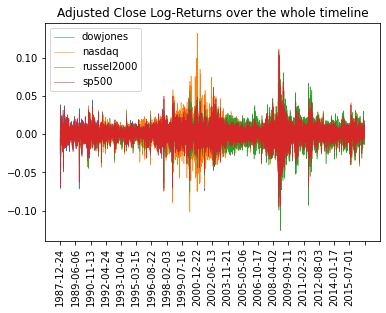

In [12]:
plot_price_data([dowjones, nasdaq, russel2000, sp500], legend, "adj_close_lr",
                "Adjusted Close Log-Returns over the whole timeline")

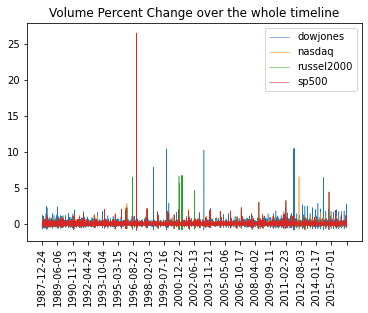

In [13]:
plot_price_data([dowjones, nasdaq, russel2000, sp500], legend, "volume_pct_change",
                "Volume Percent Change over the whole timeline")

# 2. Step 2 - Persistence Landscape From Scratch

In [ ]:
import numpy as np
from itertools import combinations
def naiveVR(points, epsilon):
    points = [np.array(x) for x in points]   
    vrComplex = [(x,y) 
                 for (x,y) in combinations(points, 2) 
                 if np.linalg.norm(x - y) < 2*epsilon]
    return np.array(vrComplex)

import numpy as np

naiveVR(dowjones["adj_close_lr"], 0.1)

In [38]:
len(list(combinations(dowjones["adj_close_lr"],2)))

26648650

In [31]:
x = naiveVR(dowjones["adj_close_lr"][1:20], 0.1)
x.shape

(171, 2)

# 3. Step 3 - Reproducing the Paper's Empirical Analysis

# 4. Step 4 - Exploring Further Avenues